Project Description:

I am interested in clustering tweets in an effort to understand what topics people are currently talking about. I have gathered up to date twitter data from a variety of hashtags that I will perform a K-Means cluster analysis on. My hope is to find distinct clusters that may provide some insight into the current topics that people are tweeting about. The tweets I have gathered were based on certain hashtags that I am interested in and in areas that I am somewhat familiar with so the resulting topics will hopefully be recognizable. If I was interested in different categories of hashtags this analysis would also allow me the versatility to cluster tweet data collected from different hashtags. 

Data Collection:

I used the tweepy package to access Twitter's API and collect all of the data for this project. I used tweepy's api.search method which returns a limited amount of tweets that match the searched query. The searches I used were hashtags and in general I tried to gather all of the tweets which contained that hashtag that occurred within the past two weeks. Because of the limitations on the API search method my analysis only includes hashtags where I was able to collect around 5,000 tweets.

Note that in order to access Twitters API through tweepy you must have a Twitter account, and a Twitter developer account. The developer account can be applied for [here](https://developer.twitter.com/en/apply-for-access).

After successfully creating a Twitter developer account you can access the proper keys and tokens which are required to access the Twitter API through tweepy. There are many tutorials out there that show how to go about accessing Twitter's API using tweepy.

Data Description:

The data that I used for this project consisted mainly of the text maintained within the tweets. The process I used to clean the text was as follows. I first removed all hyperlinks, hashtags, mentions, digits, and anything that was not in the alphabet from the text (i.e. special characters or emojis). Then, I tokenized the words using ntlk's word_tokenize function. I removed all the words that were not in the defined stop words list. Finally I used nltk's WordNetLemmatizer to lemmatize the remaining words. After the text data went through this cleaning process it was ready for analysis. 

I also removed the hashtags from the text data and created another feature containing all hashtags in a given tweet for additional analysis.  

Methods:

For this project I am using a KMeans model to cluster the collected Twitter text data. The reason I chose to use a KMeans is simply because it is one of the only unsupervised learning methods I am currently familiar with. I am not entirely sure at how well KMeans does on text data, this is one of my first projects with clustering text.

### Begin

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
pd.options.display.max_colwidth = 500

Stop words were taken from the ntlk corpus with additional words added to the list that appeared frequently but did not add value to the text.

In [2]:
sw = stopwords.words('english')
# Append rt (Retweet), rts (Retweets), u (you), amp (& character), and empty characters to the list of stop words
sw.extend(['rt', 'rts', 'u', 'amp', ''])

# Here I begin my analysis on tweet data gathered from the #actorslife hashtag.

### Word Count on Text

In [3]:
actorslife = pd.read_csv('actorslife_hashtag.csv')

The data I'm using contains the date, id, and full text of a tweet. 

In [4]:
actorslife.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5303 entries, 0 to 5302
Data columns (total 3 columns):
Datetime    5303 non-null object
Tweet Id    5303 non-null int64
Text        5303 non-null object
dtypes: int64(1), object(2)
memory usage: 124.4+ KB


In [5]:
actorslife.head(3)

,Datetime,Tweet Id,Text
0,2020-12-10 17:10:50,1337082356331528192,Let me book one job this year please please please 🙏🏽✨🙌🏽🥲 I mean...even I’m impressed by my range here. 🤓\n#actorslife #asianactress https://t.co/lKzJml91mL
1,2020-12-10 17:10:14,1337082208012693509,"BILLION STAR HOTEL by Alecs Nastoiu A touching story about a little homeless boy, learns how things are going in real life, from his mentor, Papa Rudi. CLICK HERE=&gt; https://t.co/E7FQG7kUXJ #cinematographer #cinematography #dop #dp #director #actor #actress #actorslife #filmmaker https://t.co/ZEP5LRjBau"
2,2020-12-10 17:10:11,1337082195698126853,📷 https://t.co/GQb23bDAX6 Please check out my interview with great actor/director/producer Robert Amico for Eye on Entertainment! Filmed and edited by Dr. Renah Wolzinger! ❤️ #setlife #actorslife #producer #picoftheday #photooftheday... https://t.co/gVSHMHUBT1


This function finds and removes strings which begin with a given substring from the text. It is used to remove hyperlinks, hashtags, and mentions.

In [6]:
def removeSubstring(substringList, string):
    stringList = re.split(' |\n', string)
    for substring in substringList:
        result = [i for i in stringList if substring in i]
        for string in result:
            stringList.remove(string)
    return " ".join(stringList)

This Function processes and cleans text from a tweet. It takes the text as input then does the following: lowercases, lemmatizes, removes hyperlinks, removes hashtags, removes mentions, removes digits, and removes any stop words found in the text.

In [7]:
def wc_text_processor(x):
    wn = WordNetLemmatizer()
    x = x.lower()
    # remove all https://hyperlinks, #hashtags, and @mentions from the text
    x = removeSubstring(['http://', 'https://', '#', '@'], x)
    # remove all digits from the text
    x = re.sub('\w*\d\w*','', x)
    tokens = wordpunct_tokenize(x)
    # remove words/characters that are not alphanumeric and words/characters that are in the stop words list
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(tokens)

In [8]:
actorslife_text = actorslife['Text'].apply(wc_text_processor)

After processing the text we have a clean list of words ready to be used for analysis.

In [9]:
actorslife_text.head(3)

0                                                                  [let, book, one, job, year, please, please, please, mean, even, impressed, range]
1    [billion, star, hotel, alecs, nastoiu, touching, story, little, homeless, boy, learns, thing, going, real, life, mentor, papa, rudi, click, gt]
2              [please, check, interview, great, actor, director, producer, robert, amico, eye, entertainment, filmed, edited, dr, renah, wolzinger]
Name: Text, dtype: object

Now that we have the text cleaned and ready we can do a simple word count. The following function will add all the words into one big list, then use the collections.Counter function to count all words in the text. Afterwords it plots a simple graph of the first few words ordered by frequency. 

In [156]:
# Counts the words in the text after it has been processed 
def word_count(text):
    all_text = []
    for words in text:
        all_text += words
    c = Counter(all_text)
    
    wc = pd.DataFrame(c.items(), columns=['word','count'])
    wc.sort_values(by='count',ascending=False).head(15)
    for_plot = wc.sort_values(by='count',ascending=False).head(15)
    plt.figure(figsize=(12,5))
    sns.barplot(x='word', y='count',data=for_plot, palette='cividis')
    return wc.sort_values(by='count',ascending=False).head(15)

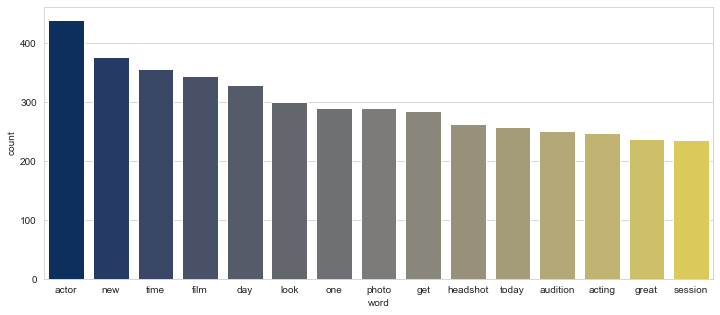

In [11]:
word_count(actorslife_text)

Here we can see that the top five highest frequency words are actor, new, time, film, and day. These words do make sense when we recognize that the text data is coming from the #actorslife hashtag. 

Another thing I've done on top of word count was to also count bigrams and trigrams within the text. This applies the ngrams function from nltk and then uses the same collections.Counter function to count the bigrams/trigrams.

In [12]:
# Counts the bigrams in the text after it has been processed
def word_count_bigrams(text):
    all_text = []
    for words in text:
        all_text += words
    bigrams = ngrams(all_text, 2)
    c = Counter(bigrams)
    bic = pd.DataFrame(c.items(), columns=['word','count'])
    return bic.sort_values(by='count',ascending=False).head(10)

In [13]:
# Counts the trigrams in the text after it has been processed
def word_count_trigrams(text):
    all_text = []
    for words in text:
        all_text += words
    trigrams = ngrams(all_text, 3)
    c = Counter(trigrams)
    bic = pd.DataFrame(c.items(), columns=['word','count'])
    return bic.sort_values(by='count',ascending=False).head(10)

In [14]:
word_count_bigrams(actorslife_text)

,word,count
2195,"(session, look)",207
2194,"(photo, session)",206
2193,"(headshot, photo)",206
4336,"(look, headshot)",135
1768,"(checked, website)",104
148,"(self, tape)",100
1041,"(checked, imdb)",77
1042,"(imdb, page)",74
419,"(short, film)",60
1516,"(feature, film)",52


In [15]:
word_count_trigrams(actorslife_text)

,word,count
2384,"(photo, session, look)",206
2383,"(headshot, photo, session)",206
4761,"(look, headshot, photo)",135
4760,"(session, look, headshot)",135
1090,"(checked, imdb, page)",73
2326,"(checked, website, checked)",45
14427,"(clothing, unlimited, believe)",39
14426,"(heart, clothing, unlimited)",39
14425,"(thespian, heart, clothing)",39
451,"(la, lake, view)",37


We can see from these results that some of the words are more commonly used together such as session and look, photo and session, headshot and photo, look and headshot, checked and website. This could show that when people are tweeting and they mention some kind of session they are often asking people to also look at the results from the session. Also we can see that these sessions are usually related to photos or headshots. It appears from these bigrams and trigrams that when people are tweeting in the #actorslife hashtag and they are using words like session, they are also referring to a photo or a headshot and inviting others to look at their content. 

### Word Count on Hashtags

Another feature we can look at from this data are the hashtags themselves. The following function takes the original text and returns a list of all the hashtags used within that text. I can then use this list to create a separate feature to analyze. 

In [16]:
# Return a list of hashtags that are contained in the text 
def getHashtags(string):
    string = string.lower()
    hashtagList = []
    stringList = re.split(' |\n', string)
    result = [i for i in stringList if '#' in i]
    for string in result:
        hashtagList.append(string)   
    return hashtagList

In [17]:
actorslife['Hashtags'] = actorslife['Text'].apply(getHashtags)

In [59]:
actorslife['Hashtags'].head(2)

0                                                                            [#asianactress]
1    [#cinematographer, #cinematography, #dop, #dp, #director, #actor, #actress, #filmmaker]
Name: Hashtags, dtype: object

Because we are using tweets that are results of the #actorslife search we can assume all of our tweets have the #actorslife hashtag in them, so we can take it out since it won't be beneficial in our analysis. 

In [21]:
actorslife['Hashtags'].apply(lambda x : x.remove('#actorslife') if ('#actorslife' in x) else x).head(3)

0                                                                            [#asianactress]
1    [#cinematographer, #cinematography, #dop, #dp, #director, #actor, #actress, #filmmaker]
2                                     [#setlife, #producer, #picoftheday, #photooftheday...]
Name: Hashtags, dtype: object

In [60]:
actorslife['Hashtags'].head(2)

0                                                                            [#asianactress]
1    [#cinematographer, #cinematography, #dop, #dp, #director, #actor, #actress, #filmmaker]
Name: Hashtags, dtype: object

Now we can perform a word count on the hashtags to find out which hashtags are most frequently used with the #actorslife hashtag.

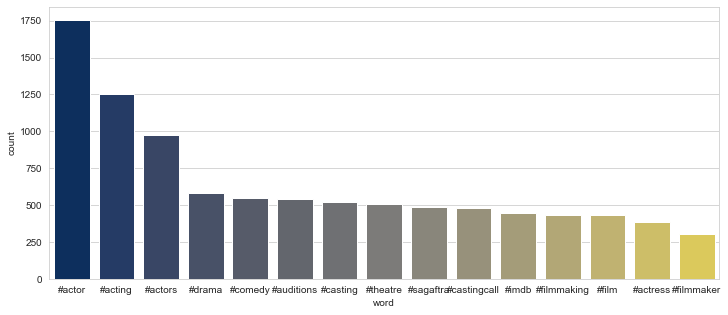

In [22]:
word_count(actorslife['Hashtags'])

A majority of people using the #actorslife hashtag also use the #actor, #acting, and #actors hashtags. This is also sensible considering that actor, actors, and acting are all words which can be considered closely realted to actorslife. Knowing which hashtags are used within a tweet along with the word count could possibly be used to gain greater insight into what the topic of the text is. 

### KMeans on Text

The text needs to be in a slightly different form than what it was for the earlier word count. This function processes the text in a way that is similar to preprocessing for word count, but in the end it returns on string value containing the resultling words instead of a list of resulting words. 

In [88]:
# Function for processing text before vectorization
def tfidf_text_processor(x):
    wn = WordNetLemmatizer()
    x = x.lower()
    # remove all https://hyperlinks, #hashtags, and @mentions from the text
    x = removeSubstring(['http://', 'https://', '#', '@'], x)
    # remove all digits from the text
    x = re.sub('\w*\d\w*','', x)
    tokens = wordpunct_tokenize(x)
    # remove words/characters that are not alphanumeric and words/characters that are in the stop words list
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return ' '.join(tokens)

In [75]:
actorslife.head(3)

,Datetime,Tweet Id,Text,Hashtags,CleanHashtags
0,2020-12-10 17:10:50,1337082356331528192,Let me book one job this year please please please 🙏🏽✨🙌🏽🥲 I mean...even I’m impressed by my range here. 🤓\n#actorslife #asianactress https://t.co/lKzJml91mL,[#asianactress],#asianactress
1,2020-12-10 17:10:14,1337082208012693509,"BILLION STAR HOTEL by Alecs Nastoiu A touching story about a little homeless boy, learns how things are going in real life, from his mentor, Papa Rudi. CLICK HERE=&gt; https://t.co/E7FQG7kUXJ #cinematographer #cinematography #dop #dp #director #actor #actress #actorslife #filmmaker https://t.co/ZEP5LRjBau","[#cinematographer, #cinematography, #dop, #dp, #director, #actor, #actress, #filmmaker]",#cinematographer #cinematography #dop #dp #director #actor #actress #filmmaker
2,2020-12-10 17:10:11,1337082195698126853,📷 https://t.co/GQb23bDAX6 Please check out my interview with great actor/director/producer Robert Amico for Eye on Entertainment! Filmed and edited by Dr. Renah Wolzinger! ❤️ #setlife #actorslife #producer #picoftheday #photooftheday... https://t.co/gVSHMHUBT1,"[#setlife, #producer, #picoftheday, #photooftheday...]",#setlife #producer #picoftheday #photooftheday...


In [89]:
actorslife_text = actorslife['Text'].apply(tfidf_text_processor)

In [90]:
actorslife_text.head(3)

0                                                          let book one job year please please please mean even impressed range
1    billion star hotel alecs nastoiu touching story little homeless boy learns thing going real life mentor papa rudi click gt
2          please check interview great actor director producer robert amico eye entertainment filmed edited dr renah wolzinger
Name: Text, dtype: object

Now we set up our TFIDF Vectorizer and call the fit_transform method on our data. This transformation converts the text into a vector of numerical values which can now be used to fit a KMeans model. 

In [91]:
tf_actorslife = TfidfVectorizer()

In [92]:
X_actorslife = tf_actorslife.fit_transform(actorslife_text)

In [93]:
pd.DataFrame(X_actorslife.toarray(), columns=tf_actorslife.get_feature_names()).head(3)

,aaand,aamir,aapke,aba,abba,abbey,abc,abduction,abigail,ability,...,𝙁𝙚𝙡𝙩,𝙘𝙪𝙩𝙚,𝙙𝙚𝙡𝙚𝙩𝙚,𝙛𝙤𝙧,𝙡𝙖𝙩𝙚𝙧,𝙢𝙞𝙜𝙝𝙩,𝙧𝙚𝙖𝙙𝙮,𝙩𝙝𝙚,𝙬𝙚𝙚𝙠,𝙮𝙤𝙪
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Using this data frame we can try to decide on a number of clusters k for our KMeans model. I am looking at the difference between within cluster sums of squares for a range of k values.

In [94]:
def plot_wcss(X):
    wcss = []
    for k in range(5,51,5):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(np.arange(5,51,5),wcss,marker="o")
    plt.xlabel('Number of Clusters, K')
    plt.ylabel('WCSS')

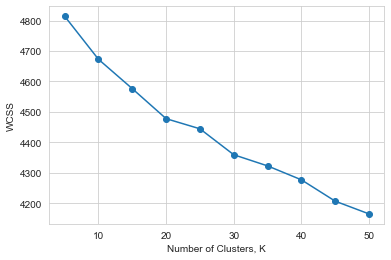

In [95]:
plot_wcss(X_actorslife)

It looks like the variability between clusters is consistently large, but between 20 and 25 clusters it shrinks and so that could be a good area to choose. Also I'm not sure how well this data can cluster so to keep the analysis simple I will stick with a smaller amount of clusters.

In [96]:
# Fit kmeans on the data, takes k clusters, X data that has been fit and transformed, and tf the models TfidfVectorizer
def fit_kmeans(k, X, tf):
    kmeans = MiniBatchKMeans(k)
    kmeans.fit(X)
    labs = kmeans.predict(X)
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = tf.get_feature_names()
    for i in range(k):
        print("Cluster %d:" % i, end='')
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind], end='')
        print()

In [99]:
fit_kmeans(20, X_actorslife, tf_actorslife)

Cluster 0: actor casting reel great york call unlimited clothing thespian believe
Cluster 1: record hear animation thing demo uplifting appreciated simplest one told
Cluster 2: checked page imdb manning conservatory clements jensen lorrel dreisbach schreiber
Cluster 3: present night purpose live let future ig career talking past
Cluster 4: checked website channel play 𝙮𝙤𝙪 finished fincher find finding fine
Cluster 5: day film one new get year acting audition week today
Cluster 6: lake hilltop isabella kern getaway kernville sequoia outdoor river quiet
Cluster 7: life working labeled assumption stereo real promise type gone ya
Cluster 8: love biopic thanks really craft picture much working shit like
Cluster 9: headshot session photo look current new favourite sharon drain one
Cluster 10: got perfect better issue new page little signed copy available
Cluster 11: show chat ticket interview virtual lovely grateful sunday michelle dorsey
Cluster 12: never feel someone say sometimes yet avoi

Looking at the list of words we can try to interpret some of the themes within each cluster. For example, cluster 6 has the words that all seem to relate to nature as well as words like quiet and getaway. Maybe this cluster has tweets related to being outside in nature in a quiet place. Kern and Kernville are also words in that cluster, it could be that there is some Kernville that is getting some attention in this #actorslife hashtag. Cluster 9 has the words headshot, session, photo, and look. From the word count we did earlier we can recognize that those words were commonly found together in bigrams and trigrams. This cluster could be a group of tweets all related to actors headshots, maybe they are getting new headshot photos taken and tweeting about it. 

### KMeans on Hashtags

Now I will perform a similar KMeans analysis but only on the hashtags contained in the tweets. To prepare the data I simply need to convert the hashtags from a list of strings to a single string of hashtags.

In [102]:
actorslife['CleanHashtags'] = actorslife['Hashtags'].apply(lambda x: ' '.join(x))

In [103]:
actorslife.head(2)

,Datetime,Tweet Id,Text,Hashtags,CleanHashtags
0,2020-12-10 17:10:50,1337082356331528192,Let me book one job this year please please please 🙏🏽✨🙌🏽🥲 I mean...even I’m impressed by my range here. 🤓\n#actorslife #asianactress https://t.co/lKzJml91mL,[#asianactress],#asianactress
1,2020-12-10 17:10:14,1337082208012693509,"BILLION STAR HOTEL by Alecs Nastoiu A touching story about a little homeless boy, learns how things are going in real life, from his mentor, Papa Rudi. CLICK HERE=&gt; https://t.co/E7FQG7kUXJ #cinematographer #cinematography #dop #dp #director #actor #actress #actorslife #filmmaker https://t.co/ZEP5LRjBau","[#cinematographer, #cinematography, #dop, #dp, #director, #actor, #actress, #filmmaker]",#cinematographer #cinematography #dop #dp #director #actor #actress #filmmaker


Again I will use the TFIDF Vectorizer to transform the text into vector of numerical values.

In [104]:
tf_actorslife = TfidfVectorizer()

In [105]:
X_actorslife = tf_actorslife.fit_transform(actorslife['CleanHashtags'])

Plotting the WCSS we can look at variability of observations between clusters.

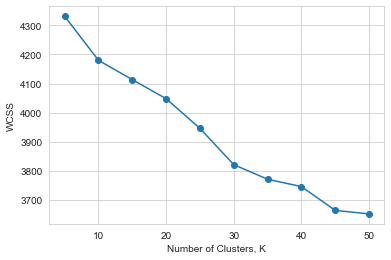

In [106]:
plot_wcss(X_actorslife)

Now we can fit a KMeans model on the hashtags to see what hashtags cluster together.

In [108]:
fit_kmeans(20, X_actorslife, tf_actorslife)

Cluster 0: pilotseason tmfa thespian models filmmaker filmmaking imdb castingcall sagaftra theatre
Cluster 1: ofmythandlegend signedonthedottedline westernmovie featurefilm flightattendant flamenco flashbackfriday flashgordon flashmovie flashpoint
Cluster 2: holidayseason stilts mondaymotivation artistsjourney wednesdaymotivation christmas play adventcalendar achristmascarol faithtalk
Cluster 3: actinginla acting 정해인 flikkers flashgordon flashmovie flashpoint flatearth fleabag flightattendant
Cluster 4: applause 30daysofgratitude newplays theater actors 정해인 flashmovie flashpoint flatearth fleabag
Cluster 5: talentagents atlactor hilaryjonesphotography nycactor actorsheadshots actorsuk laactor headshot actorlife headshots
Cluster 6: hilaryjonesphotography actorsheadshots actorsuk laactor headshot actorlife atlactor nycactor headshots talentagents
Cluster 7: filmreviews psychthemovie reviews franchise blog amazonprimevideo filmproduction movie film thebellaffairmovie
Cluster 8: theatre 정

From these clusters we can find hashtags that are commonly used together and maybe take a guess at what kind of content was contained in the tweet. For example cluster 11 has the hashtags hoodie, sweatshirt, blvckfashion and streetfashion. These tweets could be related to a new brand of sweatshirts or hoodies being sold, or that are in style. Cluster 7 has the hashtags filmreviews, reviews, movie, film, filmproduction, psychethemovie. These could be tweets dealing with reviews on movies/films, maybe even specifially the psyche movie. Or it could be that psyche the movie was clustered in with all of the rest of the movie/film hashtags. 

### Conclusion

In the end I do have a list of clusters and corresponding words/hashtags within these clusters although, it is not always an easy job to interpret the words in a given cluster. Some clusters do seem to have specific focuses or themes while others might not really make any sense to me. Sometimes I can see that there might be overlap between clusters, or that a single cluster might contain words which can be grouped separately. 

One of the challenges in interpreting these results is that I don't really know how or why the clusters are being chosen by the model. There is too much data for me to individually validate whether or not a resulting cluster actually exists in the data or whether the clusters given by the model are unreliable.

A few other things I could consider in further analysis would be the process of cleaning/preparing the text for the KMeans clustering. Currently I am using a lemmatizer to get the lemma, I could also consider using a stemmer, or  even not using either. Twitter text is a unique form of text that doesn't necessarily follow normal rules/regulations of the english language so there may be additional factors to consider because of that. There may be commonly used abbreviations or special characters that could add meaning to the tweet which I am unaware of. Also the use of emojis might be something that adds to the meaning of the text. Another element that I haven't addressed in this analysis is a retweet, currently I include all retweets in the dataset. This analysis doesn't account for a lot of things and could be enhanced in many ways. 

As an initial approach to clustering Twitter text data I do think it does a good enough job. There are unique insights that are able to be gleamed from the resulting data, especially if one is familiar with the #hashtag that is chosen. Also because of the generality of the analysis any twitter text data can be used. This analysis could be used to approach a community on twitter that someone is unfamiliar with in an effort to gain a greater understanding of the vocabulary used and the themes that are discussed commonly by people who are active in a specific twitter community.  

#### More

As I was working on this I noticed that Taylor Swift announced a new album this morning and I thought it would neat to grab some of the tweets that have been coming in on the #evermorealbum and look at the results of my analysis.

# #evermoreAlbum

In [165]:
evermore = pd.read_csv('evermorealbum_10.csv')

In [166]:
evermore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
Datetime    10000 non-null object
Tweet Id    10000 non-null int64
Text        10000 non-null object
dtypes: int64(1), object(2)
memory usage: 234.5+ KB


In [167]:
evermore.head(3)

,Datetime,Tweet Id,Text
0,2020-12-11 02:38:31,1337225218440323073,"Me, accidentally waking my friend at 7AM because of the #evermorealbum announcement: https://t.co/vrnJJioIVf"
1,2020-12-11 02:38:31,1337225218054529024,Who’s excited for @taylorswift13 new album tonight?\n\nHer hometown team is! #TaylorSwift #Evermore #Evermorealbum @TaylorNation13 #TS9 https://t.co/3UrPJr2HvU
2,2020-12-11 02:38:30,1337225217471475717,@taylornation13 Hey @taylornation13... blink twice if new merch will be dropping with the music video and album tonight 👀👀👀👀 #evermorealbum #evermorealbumcountdown #willowMusicVideo


In [168]:
text = evermore['Text'].apply(wc_text_processor)

In [169]:
text.head(3)

0                               [accidentally, waking, friend, announcement]
1                             [excited, new, album, tonight, hometown, team]
2    [hey, blink, twice, new, merch, dropping, music, video, album, tonight]
Name: Text, dtype: object

,word,count
6,album,2647
41,taylor,1627
139,hour,1416
27,pre,1374
28,order,1322
5,new,1025
29,listen,994
132,premiere,959
92,u,952
131,closer,914


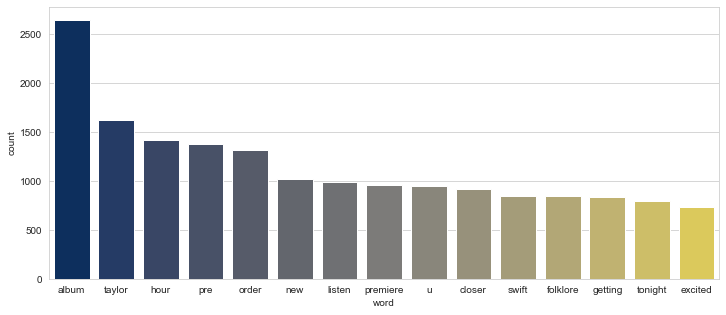

In [170]:
word_count(text)

In [171]:
word_count_bigrams(text)

,word,count
30,"(pre, order)",1319
155,"(taylor, swift)",794
5,"(new, album)",657
207,"(owns, u)",641
206,"(user, owns)",639
175,"(hour, go)",488
165,"(getting, closer)",455
166,"(closer, closer)",454
167,"(closer, premiere)",453
174,"(five, hour)",453


In [172]:
word_count_trigrams(text)

,word,count
218,"(user, owns, u)",639
175,"(getting, closer, closer)",454
176,"(closer, closer, premiere)",453
184,"(five, hour, go)",452
183,"(going, five, hour)",450
179,"(back, bit, keep)",450
178,"(premiere, back, bit)",450
177,"(closer, premiere, back)",450
181,"(keep, excitement, going)",450
182,"(excitement, going, five)",450


In [173]:
evermore['Hashtags'] = evermore['Text'].apply(getHashtags)

In [174]:
evermore.head(3)

,Datetime,Tweet Id,Text,Hashtags
0,2020-12-11 02:38:31,1337225218440323073,"Me, accidentally waking my friend at 7AM because of the #evermorealbum announcement: https://t.co/vrnJJioIVf",[#evermorealbum]
1,2020-12-11 02:38:31,1337225218054529024,Who’s excited for @taylorswift13 new album tonight?\n\nHer hometown team is! #TaylorSwift #Evermore #Evermorealbum @TaylorNation13 #TS9 https://t.co/3UrPJr2HvU,"[#taylorswift, #evermore, #evermorealbum, #ts9]"
2,2020-12-11 02:38:30,1337225217471475717,@taylornation13 Hey @taylornation13... blink twice if new merch will be dropping with the music video and album tonight 👀👀👀👀 #evermorealbum #evermorealbumcountdown #willowMusicVideo,"[#evermorealbum, #evermorealbumcountdown, #willowmusicvideo]"


In [175]:
evermore['Hashtags'].apply(lambda x : x.remove('#evermorealbum') if ('#evermorealbum' in x) else x).head(3)

0    None
1    None
2    None
Name: Hashtags, dtype: object

,word,count
4,#willowmusicvideo,2285
0,#taylorswift,1638
6,#evermoreatmidnight,997
3,#evermorealbumcountdown,603
1,#evermore,582
5,#willowatmidnight,465
28,#evermorealbumin6hours,372
7,#folklore,327
16,#willow,311
35,#evermoreiscoming,166


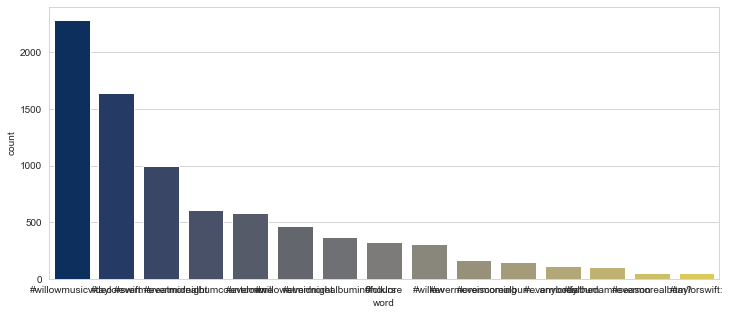

In [176]:
word_count(evermore['Hashtags'])

In [177]:
text = evermore['Text'].apply(tfidf_text_processor)

In [192]:
tf = TfidfVectorizer()

In [193]:
X = tf.fit_transform(text)

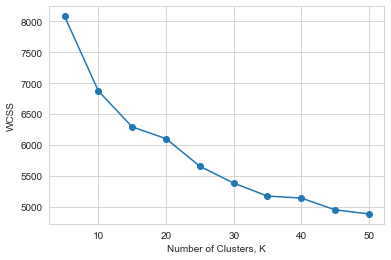

In [180]:
plot_wcss(X)

In [194]:
fit_kmeans(20, X, tf)

Cluster 0: mood convince otherwise whole today always cannot great filter happened
Cluster 1: digital edition song new tonight learn booklet album exclusive standard
Cluster 2: spite beer fine candle tear finest finally find finding 𝚠𝚑𝚊𝚝
Cluster 3: start trending paste copy taylor album excited like wait evermore
Cluster 4: listen order pre minus watch track see use album excited
Cluster 5: swift taylor tour next issue trust reason directed dancer credit
Cluster 6: road taken look real good besties awake morning finding final
Cluster 7: owns user taylor album 𝚠𝚑𝚊𝚝 finalchapter fiona finlay finished finish
Cluster 8: hour three go till left four le omg minute wait
Cluster 9: reqs willing place repeat first listen finalchapter finally find finding
Cluster 10: major freak definitely finger finally find finding fine finest 𝚠𝚑𝚊𝚝
Cluster 11: tomorrow nap alarm set wake take lunch weeping work agenda
Cluster 12: willow mv get stream trend steam push view reply goal
Cluster 13: press hearing p

In [182]:
evermore['CleanHashtags'] = evermore['Hashtags'].apply(lambda x: ' '.join(x))

In [183]:
tf1 = TfidfVectorizer()

In [184]:
X1 = tf1.fit_transform(evermore['CleanHashtags'])

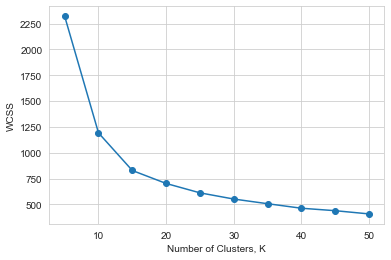

In [185]:
plot_wcss(X1)

In [186]:
fit_kmeans(10, X1, tf1)

Cluster 0: evermorealbumcountdown taylorswift evermorealbum folklore willowmusicvideo exile evermoreatmidnight evermorebraids evermorebumcountdown evermorecountdown
Cluster 1: evermore evermoreiscoming ts9 evermoreatmidnight taylorswift evermorealbumin5hours taylorswiftevermore folklore willowmusicvideo folkloreondisneyplus
Cluster 2: willowmusicvideo evermore مقاطعه_المنتجات_الفرنسيه44 evermorebumcountdown evermorecountdown evermoreheader evermorein3hours evermorein6hours evermoreiscoming evermoreiscomming
Cluster 3: taylorswift willowmusicvideo evermore evermoreiscoming evermoreatmidnight evermoreiscomming evermorebraids evermorebumcountdown evermorecountdown evermoreheader
Cluster 4: evermorealbum evermore willowmusicvideo evermoreatmidnight taylorswift evermoreiscoming evermorealbumin3hours evermorealbumcountdown evermorebraids evermorebumcountdown
Cluster 5: evermoreatmidnight willowatmidnight taylorswift willowmusicvideo evermorealbum evermore evermoreiscoming willow evermorealbu

Not sure how interpretable these are since the leading hashtags can be found in all of the clusters. There is just an overwhelming dominance on a couple of the hashtags, it maybe that that factor is prevent clustering. Or it could also be that clustering on hashtags is more difficult. 